# Project 1 -- Time and Global State

## Instructions

Please read carefully:

* Solve the project yourself. No teamwork.
* If you have questions, please post these in the public channel on Slack. The answers may be relevant to others as well. 
* Feel free to import and use any additional Python packages you need.
* Keep in mind that the correctness of your solution will also be verified on a *different input file*. This means that you are asked to provide an algorithm, not to hardcode the answer. If your solution for a task works only on the provided input (i.e., `sampledb.log` file), but does not work on the held back input, you will get only 50% of the points for that task.
* You are allowed to solve the project using a different programming language. In this case, please send me your full code and instructions how to run it.
* Make sure to fill in your `student_name` in the following block below.

In [28]:
student_name = 'David Mihola' # fill with your student name
assert student_name != 'your_student_name', 'Please fill in your student_name before you start.'
mattrikel_nummer = 12211951

## Setup

In this mini-project, you will use your knowledge of logical clocks to analyse a sample distributed system execution. You are given a sample log file `sampledb.log` containing an event log of five communicating processes: Alice, Bob, Carol, Dave and Eve. The log file format is as follows:
```
(<event name>)\n(<host>) (<local_clock>)
```
The code below installs the utility `gdown` and downloads `sampledb.log`.

In [29]:
# DO NOT CHANGE THESE LINES
!pip install gdown
!gdown https://drive.google.com/file/d/1s7BALY1RQyHjk06Okul7_lwUpoizZVNZ/view?usp=sharing --fuzzy

Defaulting to user installation because normal site-packages is not writeable
Downloading...
From: https://drive.google.com/uc?id=1s7BALY1RQyHjk06Okul7_lwUpoizZVNZ
To: /mnt/sdc3/david/projs/fault_tolerant_systems/sampledb.log
100%|██████████████████████████████████████| 3.09k/3.09k [00:00<00:00, 20.2MB/s]


To inspect the `sampledb.log` file click on the folder icon in your Google Colab called `Files` on the left. 

Examples of events in the log file:
* Event `Making progress` finished on the host `Bob` at its local time 2.
```
Making progress 
Bob {"Bob":2}
```
* Event `Receive event` is a message receive event at the host `Alice` at its local clock time 3. The message comes from host `Bob` sent at its local time 2.
```
Receive event
Alice {"Alice":3, "Bob":2}
```
* Event `Checkpoint` takes place on the host `Carol` at its local time 12.
```
Checkpoint
Carol {"Carol":12}
```

The code below will help you to correctly parse the input file.

In [30]:
# DO NOT CHANGE THESE LINES
import re
import ast

regex = '(.*)\n(\S*) ({.*})'
events = []

with open(f'sampledb.log') as f:
    events = [{'event': event, 'host': host, 'clock': ast.literal_eval(clock)}
               for event, host, clock in re.findall(regex, f.read())]
print('Events:', events)
print('Total number of events:', len(events))

Events: [{'event': 'Init event', 'host': 'Alice', 'clock': {'Alice': 1}}, {'event': 'Init event', 'host': 'Bob', 'clock': {'Bob': 1}}, {'event': 'Send event', 'host': 'Alice', 'clock': {'Alice': 2}}, {'event': 'Making progress', 'host': 'Bob', 'clock': {'Bob': 2}}, {'event': 'Receive event', 'host': 'Bob', 'clock': {'Bob': 3, 'Alice': 2}}, {'event': 'Computing', 'host': 'Alice', 'clock': {'Alice': 3}}, {'event': 'Checkpoint', 'host': 'Alice', 'clock': {'Alice': 4}}, {'event': 'Making progress', 'host': 'Bob', 'clock': {'Bob': 4}}, {'event': 'Init event', 'host': 'Carol', 'clock': {'Carol': 1}}, {'event': 'Init event', 'host': 'Dave', 'clock': {'Dave': 1}}, {'event': 'Init event', 'host': 'Eve', 'clock': {'Eve': 1}}, {'event': 'Send event', 'host': 'Carol', 'clock': {'Carol': 2}}, {'event': 'Checkpoint', 'host': 'Carol', 'clock': {'Carol': 3}}, {'event': 'Send event', 'host': 'Carol', 'clock': {'Carol': 4}}, {'event': 'Send event', 'host': 'Bob', 'clock': {'Bob': 5}}, {'event': 'Receive

## Process data into better format to plot them

In [31]:
# !pip install py-linq
from py_linq import Enumerable
events_grouped = Enumerable(events).group_by(["name"], lambda x: x["host"]).order_by(lambda x: x.key.name) # group the events by each person and order them alphabetically
names_enumerable = events_grouped.select(lambda x: x.key.name) # get the names of each person and keep the enumerable
names = names_enumerable.to_list() 

events_by_names_ordered_dict = dict( # create a dictornary from tuples
                                 tuple( # make tuples ('name', 'events')
                                    events_grouped.select(lambda x: [x.key.name, # name of the person
                                                                     x.select(lambda y: [y["event"], list(y["clock"].items())]) # select the event name and time information for one person
                                                                      .order_by(lambda y: y[1][0][1])  # events seem to be order, but might not be always the case, order them to be sure from 1 to N
                                                                      .to_list() # make list of the events for one person
                                                                    ]
                                                         )
                                                  .to_list() # make a list of lists ['name', 'events']
                                      )
                                    )

for _ in range(1000): # 'while True:' would never finish, if the events are invalid
    missplaced_recieve_event = (Enumerable(events_by_names_ordered_dict.values()).select_many(lambda x: x) # make one list of events from all people
                                                                                 .where(lambda x: x[0] == "Receive event" and x[1][0][1] <= x[1][1][1]) # choose missplaced 'Recieve events'
                                                                                 .select(lambda x: x[1]) # select the time information
                                                                                 .order_by(lambda x: x[1][1]) # order the missplaced events by the time they happen from 1 to N
                                                                                 .first_or_default()) # take the first one or 'None'
    if missplaced_recieve_event == None: # no more missplaced events
        break
    
    missplaced_name = missplaced_recieve_event[0][0] # get person X, whose timeline isn't correct
    index = missplaced_recieve_event[0][1] - 1
    nops = missplaced_recieve_event[1][1] - missplaced_recieve_event[0][1] + 1 # get the number of nooperations the person X must do to correct their timeline
    timeline = events_by_names_ordered_dict[missplaced_name]
    for i in range(nops):
        timeline.insert(index, ["Nop", [(missplaced_name, index + nops - i)]]) # correct the timeline
    
    for event in timeline[index + nops:]:
        event[1][0] = (event[1][0][0], event[1][0][1] + nops) 

    for name in names_enumerable.where(lambda x: x != missplaced_name): # get other people
        timeline = events_by_names_ordered_dict[name]
        for moved in Enumerable(timeline).where(lambda x: len(x[1]) > 1 and x[1][1][0] == missplaced_name and x[1][1][1] > index): # chose events affected by the change of timeline of person X
            moved[1][1] = (missplaced_name, moved[1][1][1] + nops) # adjust corrected timeline in timelines of other people

max_length = Enumerable(events_by_names_ordered_dict.values()).max(lambda x: len(x)) # find the longes timeline
for key, value in events_by_names_ordered_dict.items():
    while len(value) <= max_length:
        value.append(["Nop", [(key, len(value))]]) # padd the shorter timelines


## Plot the processed data

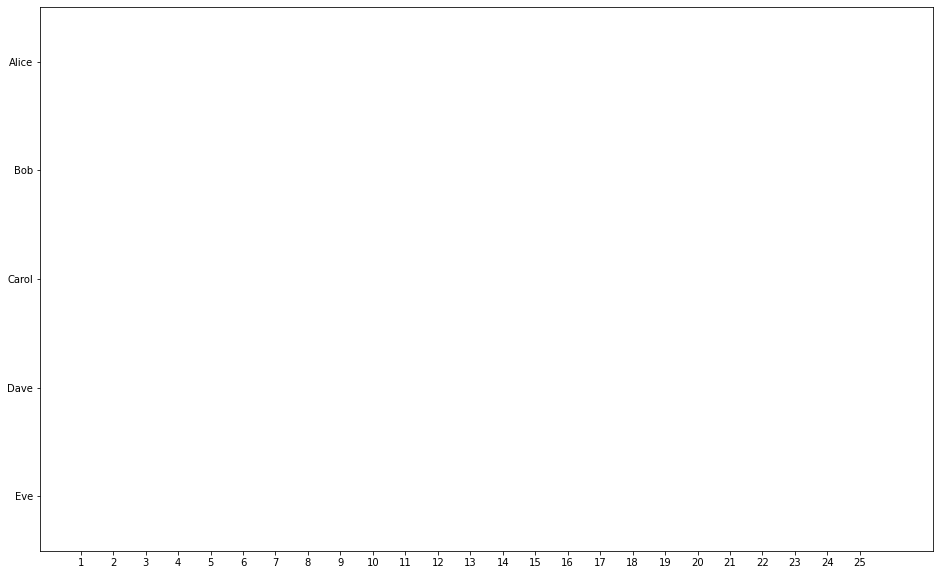

In [47]:
# !pip install numpy
# !pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

names_reversed = names.copy()
names_reversed.reverse()

figure, axis = plt.subplots(figsize=(16, 10))
lin_space = np.linspace(0, 250, 250)
line = np.ones(250, dtype=np.uint32) * 2
other_line = np.ones(250, dtype=np.uint32) * 3
plot, = axis.plot(lin_space, line)
plot, = axis.plot(lin_space, other_line)
axis.set_xticks(np.arange(25) * 10, np.arange(1, 26))
axis.set_yticks(np.arange(len(names_reversed)) + 0.5, names_reversed)
axis.set_ylim(0, 5)


def update(time, lin_space, line, plot):
    plot.set_data(lin_space[:time], line[:time])
    return plot,

line_animation = animation.FuncAnimation(figure, update, 250, fargs=[lin_space, line, plot], interval=10, blit=True)

plt.show()


In [33]:
events_by_names_ordered_dict[names[0]]

[['Init event', [('Alice', 1)]],
 ['Send event', [('Alice', 2)]],
 ['Computing', [('Alice', 3)]],
 ['Checkpoint', [('Alice', 4)]],
 ['Send event', [('Alice', 5)]],
 ['Receive event', [('Alice', 6), ('Carol', 4)]],
 ['Send event', [('Alice', 7)]],
 ['Making progress', [('Alice', 8)]],
 ['Checkpoint', [('Alice', 9)]],
 ['Nop', [('Alice', 10)]],
 ['Nop', [('Alice', 11)]],
 ['Receive event', [('Alice', 12), ('Bob', 11)]],
 ['Computing', [('Alice', 13)]],
 ['Nop', [('Alice', 14)]],
 ['Receive event', [('Alice', 15), ('Bob', 14)]],
 ['Checkpoint', [('Alice', 16)]],
 ['Receive event', [('Alice', 17), ('Dave', 7)]],
 ['Nop', [('Alice', 18)]],
 ['Nop', [('Alice', 19)]],
 ['Receive event', [('Alice', 20), ('Bob', 19)]],
 ['Making progress', [('Alice', 21)]],
 ['Nop', [('Alice', 22)]],
 ['Receive event', [('Alice', 23), ('Bob', 22)]],
 ['Nop', [('Alice', 23)]],
 ['Nop', [('Alice', 24)]]]

In [34]:
events_by_names_ordered_dict[names[1]]

[['Init event', [('Bob', 1)]],
 ['Making progress', [('Bob', 2)]],
 ['Receive event', [('Bob', 3), ('Alice', 2)]],
 ['Making progress', [('Bob', 4)]],
 ['Send event', [('Bob', 5)]],
 ['Receive event', [('Bob', 6), ('Carol', 4)]],
 ['Receive event', [('Bob', 7), ('Alice', 5)]],
 ['Checkpoint', [('Bob', 8)]],
 ['Receive event', [('Bob', 9), ('Alice', 7)]],
 ['Checkpoint', [('Bob', 10)]],
 ['Send event', [('Bob', 11)]],
 ['Receive event', [('Bob', 12), ('Carol', 11)]],
 ['Checkpoint', [('Bob', 13)]],
 ['Send event', [('Bob', 14)]],
 ['Computing', [('Bob', 15)]],
 ['Processing results', [('Bob', 16)]],
 ['Receive event', [('Bob', 17), ('Dave', 16)]],
 ['Checkpoint', [('Bob', 18)]],
 ['Send event', [('Bob', 19)]],
 ['Send event', [('Bob', 20)]],
 ['Checkpoint', [('Bob', 21)]],
 ['Send event', [('Bob', 22)]],
 ['Nop', [('Bob', 22)]],
 ['Nop', [('Bob', 23)]],
 ['Nop', [('Bob', 24)]]]

In [35]:
events_by_names_ordered_dict[names[2]]

[['Init event', [('Carol', 1)]],
 ['Send event', [('Carol', 2)]],
 ['Checkpoint', [('Carol', 3)]],
 ['Send event', [('Carol', 4)]],
 ['Checkpoint', [('Carol', 5)]],
 ['Receive event', [('Carol', 6), ('Bob', 5)]],
 ['Making progress', [('Carol', 7)]],
 ['Checkpoint', [('Carol', 8)]],
 ['Receive event', [('Carol', 9), ('Dave', 7)]],
 ['Receive event', [('Carol', 10), ('Alice', 7)]],
 ['Send event', [('Carol', 11)]],
 ['Making progress', [('Carol', 12)]],
 ['Receive event', [('Carol', 13), ('Bob', 11)]],
 ['Checkpoint', [('Carol', 14)]],
 ['Nop', [('Carol', 15)]],
 ['Nop', [('Carol', 16)]],
 ['Receive event', [('Carol', 17), ('Dave', 16)]],
 ['Nop', [('Carol', 18)]],
 ['Nop', [('Carol', 19)]],
 ['Receive event', [('Carol', 20), ('Dave', 19)]],
 ['Checkpoint', [('Carol', 21)]],
 ['Receive event', [('Carol', 22), ('Bob', 14)]],
 ['Checkpoint', [('Carol', 23)]],
 ['Receive event', [('Carol', 24), ('Bob', 22)]],
 ['Nop', [('Carol', 24)]]]

In [36]:
events_by_names_ordered_dict[names[3]]

[['Init event', [('Dave', 1)]],
 ['Nop', [('Dave', 2)]],
 ['Receive event', [('Dave', 3), ('Carol', 2)]],
 ['Checkpoint', [('Dave', 4)]],
 ['Receive event', [('Dave', 5), ('Eve', 2)]],
 ['Checkpoint', [('Dave', 6)]],
 ['Send event', [('Dave', 7)]],
 ['Receive event', [('Dave', 8), ('Alice', 5)]],
 ['Nop', [('Dave', 9)]],
 ['Nop', [('Dave', 10)]],
 ['Nop', [('Dave', 11)]],
 ['Receive event', [('Dave', 12), ('Carol', 11)]],
 ['Checkpoint', [('Dave', 13)]],
 ['Receive event', [('Dave', 14), ('Alice', 7)]],
 ['Checkpoint', [('Dave', 15)]],
 ['Send event', [('Dave', 16)]],
 ['Making progress', [('Dave', 17)]],
 ['Checkpoint', [('Dave', 18)]],
 ['Send event', [('Dave', 19)]],
 ['Receive event', [('Dave', 20), ('Bob', 5)]],
 ['Making progress', [('Dave', 21)]],
 ['Nop', [('Dave', 22)]],
 ['Receive event', [('Dave', 23), ('Bob', 22)]],
 ['Nop', [('Dave', 23)]],
 ['Nop', [('Dave', 24)]]]

In [37]:
events_by_names_ordered_dict[names[4]]

[['Init event', [('Eve', 1)]],
 ['Send event', [('Eve', 2)]],
 ['Checkpoint', [('Eve', 3)]],
 ['Receive event', [('Eve', 4), ('Carol', 2)]],
 ['Computing', [('Eve', 5)]],
 ['Processing results', [('Eve', 6)]],
 ['Nop', [('Eve', 7)]],
 ['Receive event', [('Eve', 8), ('Dave', 7)]],
 ['Making progress', [('Eve', 9)]],
 ['Checkpoint', [('Eve', 10)]],
 ['Receive event', [('Eve', 11), ('Alice', 7)]],
 ['Checkpoint', [('Eve', 12)]],
 ['Nop', [('Eve', 13)]],
 ['Nop', [('Eve', 14)]],
 ['Nop', [('Eve', 15)]],
 ['Nop', [('Eve', 16)]],
 ['Nop', [('Eve', 17)]],
 ['Receive event', [('Eve', 18), ('Bob', 17)]],
 ['Checkpoint', [('Eve', 19)]],
 ['Receive event', [('Eve', 20), ('Dave', 19)]],
 ['Computing', [('Eve', 21)]],
 ['Processing results', [('Eve', 22)]],
 ['Receive event', [('Eve', 23), ('Bob', 20)]],
 ['Nop', [('Eve', 23)]],
 ['Nop', [('Eve', 24)]]]

## 1 - Visualize Execution [5+ points]

**Your task:** Visualize the execution (similarly to the visualizations in the lecture). The author of the best visualization gets 3 points on top!

In [38]:
### START CODE HERE ###
None
### END CODE HERE ###

## 2 - Count Concurrent Events [5 points]

**Your task**: Count the *total number of unique* concurrent event pairs in the log file.

In [39]:
def count_concurrent_events(events):
  ### START CODE HERE ###
  None
  ### END CODE HERE ###

print('Number of concurrent event pairs:', count_concurrent_events(events))

Number of concurrent event pairs: None


## 3 - Assign Vector Clocks [4 points]

**Your task:** Assign vector timestamps to each event. Annotate the event captions with the corresponting vector timestamp. E.g., 
```
`Dummy event` --> `Dummy event [0,12,2,4,0]`.
```


In [40]:
def assign_vector_timestamps(events):
  ### START CODE HERE ###
  None
  ### END CODE HERE ###

print(assign_vector_timestamps(events))

None


## 4 - Rollback Recovery [6 points]
All events annotated with the `Checkpoint` in the title are checkpointing events. According to the provided log file `sampledb.log`, the hosts Alice, Bob, Carol, Dave and Eve are at their logical time 17, 22, 20, 18 and 17 respectively. Once of a sudden, Bob fails and has to rollback at least to its latest checkpoint.

**Your task:** Write an algorithm to calculate the correct recovery line given one or multiple host failures.

In [41]:
def recovery_line(events, failed_processes):
  ### START CODE HERE ###
  None
  ### END CODE HERE ###

print("Computed recovery line: ", recovery_line(events, ["Bob"]))

Computed recovery line:  None


## 5 - How to Submit Your Solution?
Download your notebook (File --> Download --> Download .ipynb) and send per email to [saukh@tugraz.at](mailto:saukh@tugraz.at).